# An Deep Learning Example with PyTorch - Fashion MNIST
[Jian Tao](https://coehpc.engr.tamu.edu/people/jian-tao/), Texas A&M University

Feb 13, 2020

****

Converted from the Jupyter notebook by


[Michael Li](https://wayofnumbers.com/)


[PyTorch_Tutorial_Basic_v1.ipynb](https://github.com/wayofnumbers/SideProjects/blob/master/PyTorch_Tutorial_Basic_v1.ipynb)


****
* Context

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

* Content

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

* Labels

Each training and test example is assigned to one of the following labels:

 0. T-shirt/top
 1. Trouser
 2. Pullover
 3. Dress
 4. Coat
 5. Sandal
 6. Shirt
 7. Sneaker
 8. Bag
 9. Ankle boot


In [44]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)     # On by default, leave it here for clarity

In [45]:
# check PyTorch versions
print(torch.__version__)
print(torchvision.__version__)

1.3.1
0.4.2


In [46]:
# Use standard FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

In [47]:
# Build the neural network, expand on top of nn.Module
class Network(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

    self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)

  # define forward function
  def forward(self, t):
    # conv 1
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # conv 2
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # fc1
    t = t.reshape(-1, 12*4*4)
    t = self.fc1(t)
    t = F.relu(t)

    # fc2
    t = self.fc2(t)
    t = F.relu(t)

    # output
    t = self.out(t)
    # don't need softmax here since we'll use cross-entropy as activation.

    return t

In [48]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [49]:
# import modules to build RunBuilder and RunManager helper classes
from collections  import OrderedDict
from collections import namedtuple
from itertools import product

# Read in the hyper-parameters and return a Run namedtuple containing all the 
# combinations of hyper-parameters
class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs

In [50]:
# Helper class, help track loss, accuracy, epoch time, run time, 
# hyper-parameters etc. Also record to TensorBoard and write into csv, json
class RunManager():
  def __init__(self):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.network = None
    self.loader = None
    self.tb = None

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def begin_run(self, run, network, loader):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1

    self.network = network
    self.loader = loader
    self.tb = SummaryWriter(comment=f'-{run}')

    images, labels = next(iter(self.loader))
    grid = torchvision.utils.make_grid(images)

    self.tb.add_image('images', grid)
    self.tb.add_graph(self.network, images)

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.tb.close()
    self.epoch_count = 0

  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0

  # 
  def end_epoch(self):
    # calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # record epoch loss and accuracy
    loss = self.epoch_loss / len(self.loader.dataset)
    accuracy = self.epoch_num_correct / len(self.loader.dataset)

    # Record epoch loss and accuracy to TensorBoard 
    self.tb.add_scalar('Loss', loss, self.epoch_count)
    self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

    # Record params to TensorBoard
    for name, param in self.network.named_parameters():
      self.tb.add_histogram(name, param, self.epoch_count)
      self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["accuracy"] = accuracy
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # display epoch information and show progress
    clear_output(wait=True)
    display(df)

  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss += loss.item() * self.loader.batch_size

  # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
  
  # save end results of all runs into csv, json for further a
  def save(self, fileName):

    pd.DataFrame.from_dict(
        self.run_data, 
        orient = 'columns',
    ).to_csv(f'{fileName}.csv')

    with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
      json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [51]:
# put all hyper params into a OrderedDict, easily expandable
params = OrderedDict(
    lr = [.01, .001],
    batch_size = [100, 1000],
    shuffle = [False]
)
epochs = 5

In [52]:
m = RunManager()

# get all runs from params using RunBuilder class
for run in RunBuilder.get_runs(params):

    # if params changes, following line of code should reflect the changes too
    network = Network()
    loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size)
    optimizer = optim.Adam(network.parameters(), lr=run.lr)

    m.begin_run(run, network, loader)
    for epoch in range(epochs):
      
      m.begin_epoch()
      for batch in loader:
        
        images = batch[0]
        labels = batch[1]
        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        m.track_loss(loss)
        m.track_num_correct(preds, labels)

      m.end_epoch()
    m.end_run()

# when all runs are done, save results to files
m.save('results')

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,0.604027,0.769633,8.693011,8.771087,0.010,100,False
1,1,2,0.400272,0.851583,9.055711,17.989195,0.010,100,False
2,1,3,0.363312,0.864083,8.705267,26.841704,0.010,100,False
3,1,4,0.345722,0.871233,8.682577,35.656434,0.010,100,False
4,1,5,0.338006,0.874983,8.963626,44.771517,0.010,100,False
5,2,1,1.075683,0.583400,5.053771,5.535357,0.010,1000,False
6,2,2,0.578071,0.772433,4.994835,10.684224,0.010,1000,False
7,2,3,0.481003,0.819367,4.977835,15.808348,0.010,1000,False
8,2,4,0.424522,0.844533,4.897492,20.852629,0.010,1000,False
9,2,5,0.385553,0.858567,5.143966,26.144370,0.010,1000,False


In [53]:
# helper function to calculate all predictions of train set
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images, labels = batch

    preds = model(images)
    all_preds = torch.cat(
        (all_preds, preds),
        dim = 0
    )
  return all_preds

In [54]:
# bigger batch size since we only do FP
prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=1000)
train_preds = get_all_preds(network, prediction_loader)

In [55]:
!pip install scikit-plot

Defaulting to user installation because normal site-packages is not writeable


In [56]:
# use scikitplot to plot the confusion matrix
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import scikitplot as skplt

cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
cm

array([[4935,   62,  206,  366,   78,    8,  272,    1,   69,    3],
       [  12, 5712,   35,  148,   27,    5,   59,    0,    2,    0],
       [  53,   14, 4190,   54, 1271,    5,  316,    0,   97,    0],
       [ 228,  185,  123, 4926,  354,    5,  151,    0,   28,    0],
       [  10,   12,  788,  202, 4758,    2,  175,    0,   52,    1],
       [   0,    1,    1,    7,    2, 5392,    0,  488,   23,   86],
       [1340,   31, 2102,  255, 1337,    2,  802,    1,  129,    1],
       [   0,    0,    0,    0,    0,  341,    0, 5282,   11,  366],
       [  23,    6,  110,   23,   48,   65,   62,   33, 5621,    9],
       [   1,    0,    0,    3,    1,   54,    0,  400,    9, 5532]])

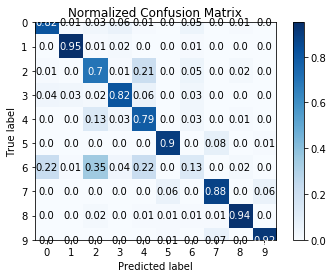

In [57]:
skplt.metrics.plot_confusion_matrix(train_set.targets,train_preds.argmax(dim=1), normalize=True)

In [58]:
# use ngrok to display TensorBoard on Colab
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip


--2020-02-14 02:52:55--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.228.157.109, 52.20.119.24, 52.4.202.19, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.228.157.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.3’

ngrok-stable-linux- 100%[===================>]  13.13M  15.9MB/s    in 0.8s    

2020-02-14 02:52:56 (15.9 MB/s) - ‘ngrok-stable-linux-amd64.zip.3’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [59]:
LOG_DIR = './runs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [60]:
get_ipython().system_raw('./ngrok http 6006 &')


In [61]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://3fe4ef19.ngrok.io
